In [1]:
!pip install -q efficientnet
!pip install plotly

In [6]:
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Convolution2D,Dense,MaxPool2D,Activation,Dropout,Flatten
from keras.layers import GlobalAveragePooling2D
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.layers.normalization import BatchNormalization
import os 
import pandas as pd
import plotly.graph_objs as go
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

In [7]:
os.listdir('/home/jasmineljw95/notebooks/English_Study_Project/')

['test.csv',
 'plant-pathology-2020-fgvc7.zip',
 'sample_submission.csv',
 'images',
 'train.csv',
 '.ipynb_checkpoints',
 'Practice.ipynb']

In [8]:
print(train.shape)
print(test.shape)
print(sub.shape)

(1821, 5)
(1821, 1)
(1821, 5)


In [9]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sub = pd.read_csv('sample_submission.csv')
train['image_id']=train['image_id']+'.jpg'
test['image_id']=test['image_id']+'.jpg'
train.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0.jpg,0,0,0,1
1,Train_1.jpg,0,1,0,0
2,Train_2.jpg,1,0,0,0
3,Train_3.jpg,0,0,1,0
4,Train_4.jpg,1,0,0,0


Text(0, 0.5, '')

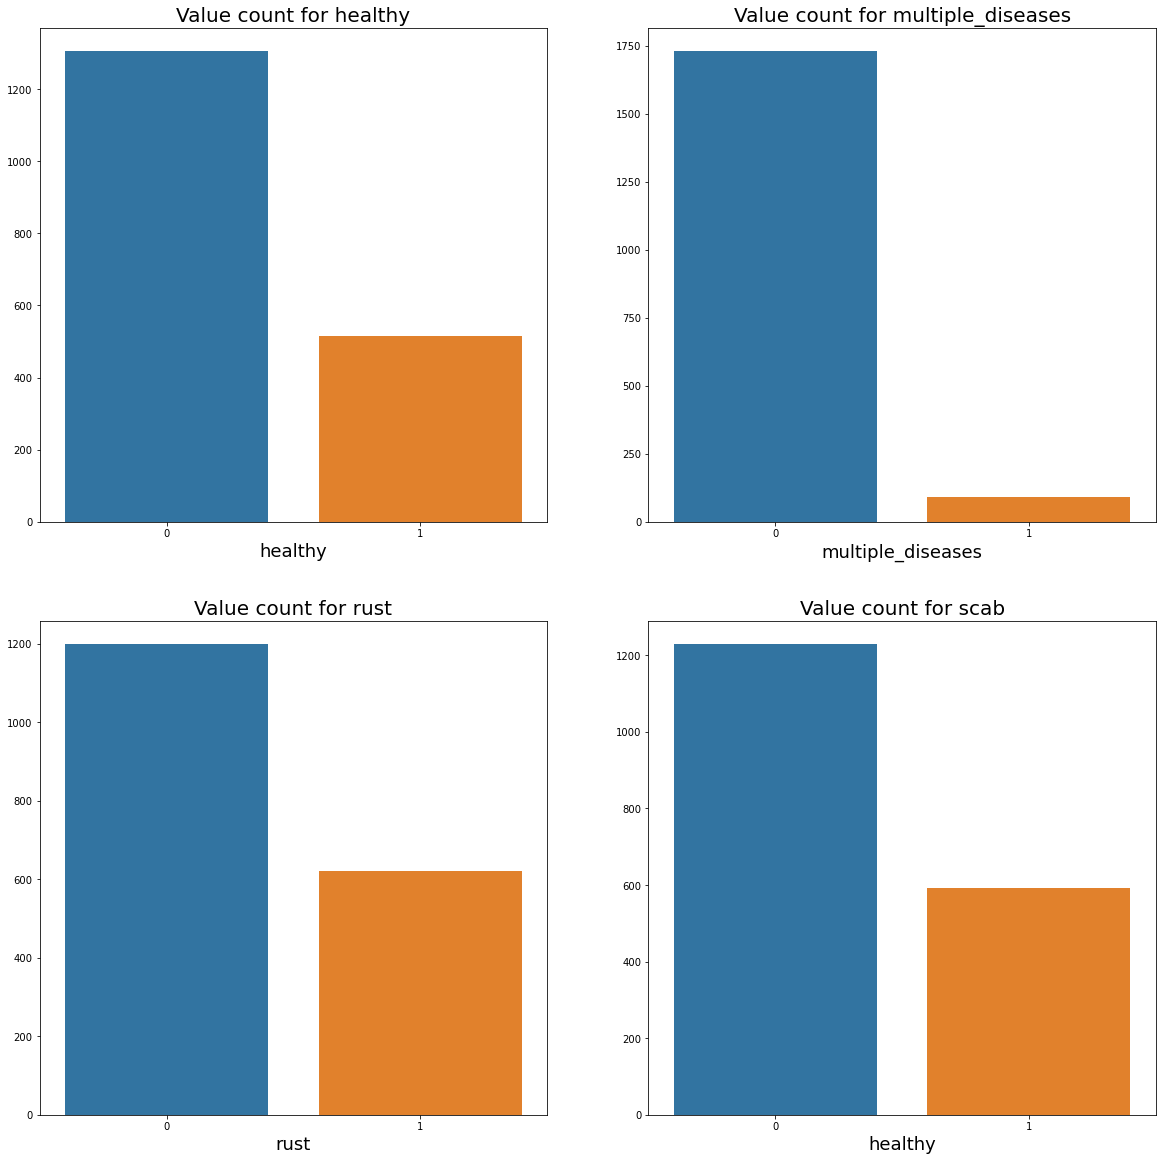

In [10]:
fig,ax=plt.subplots(2,2,figsize=(20,20))
sns.barplot(y=train.healthy.value_counts(),x=train.healthy.value_counts().index,ax=ax[0,0])
ax[0,0].set_title("Value count for healthy",size=20)
ax[0,0].set_xlabel('healthy',size=18)
ax[0,0].set_ylabel('',size=18)

sns.barplot(y=train.multiple_diseases.value_counts(),x=train.multiple_diseases.value_counts().index,ax=ax[0,1])
ax[0,1].set_title("Value count for multiple_diseases",size=20)
ax[0,1].set_xlabel('multiple_diseases',size=18)
ax[0,1].set_ylabel('',size=18)

sns.barplot(y=train.rust.value_counts(),x=train.rust.value_counts().index,ax=ax[1,0])
ax[1,0].set_title("Value count for rust",size=20)
ax[1,0].set_xlabel('rust',size=18)
ax[1,0].set_ylabel('',size=18)

sns.barplot(y=train.scab.value_counts(),x=train.scab.value_counts().index,ax=ax[1,1])
ax[1,1].set_title("Value count for scab",size=20)
ax[1,1].set_xlabel('healthy',size=18)
ax[1,1].set_ylabel('',size=18)

In [19]:
image=cv2.imread("/home/jasmineljw95/notebooks/English_Study_Project/images/"+ file)

In [20]:
img=[]
filename=train.image_id
for file in filename:
    res=cv2.resize(image,(256,256))
    img.append(res)
img=np.array(img)

In [21]:
print(img.shape)

(1821, 256, 256, 3)


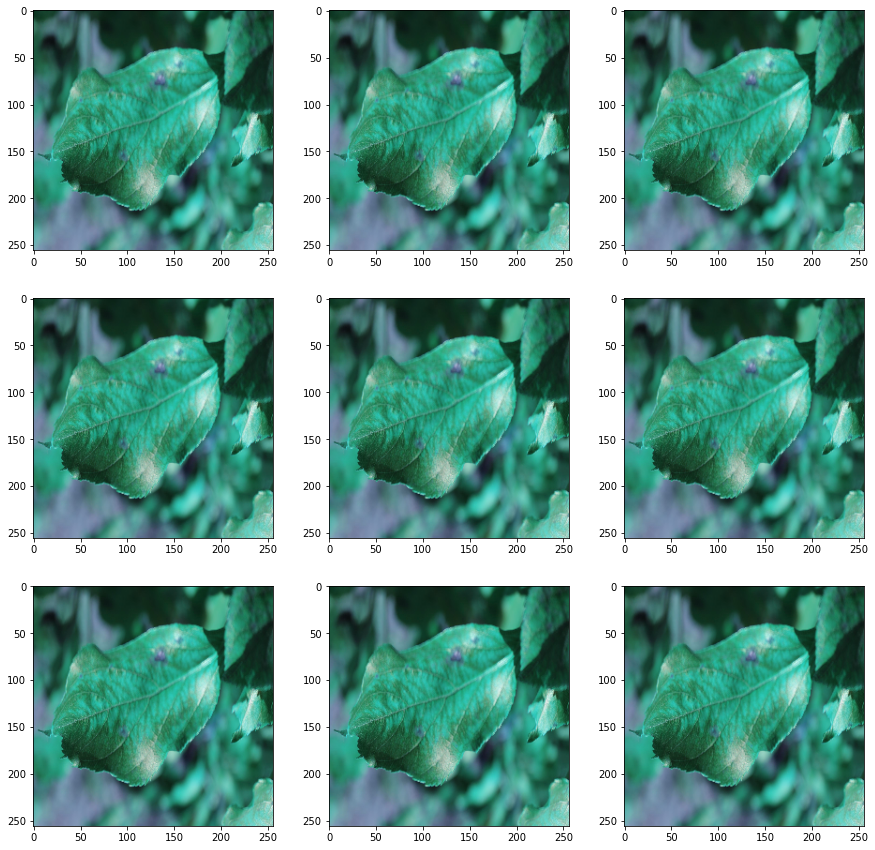

In [22]:
plt.figure(figsize=(15,15))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(img[i])

In [23]:
train_labels = np.float32(train.loc[:, 'healthy':'scab'].values)

train, val = train_test_split(train, test_size = 0.15)

In [24]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator( horizontal_flip=True,
    vertical_flip=True,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=.1,
    fill_mode='nearest',
    shear_range=0.1,
    rescale=1/255,
    brightness_range=[0.5, 1.5])

In [25]:
train_generator=train_datagen.flow_from_dataframe(train,directory='/home/jasmineljw95/notebooks/English_Study_Project/images/',
                                                      target_size=(384,384),
                                                      x_col="image_id",
                                                      y_col=['healthy','multiple_diseases','rust','scab'],
                                                      class_mode='raw',
                                                      shuffle=False,
                                                       subset='training',
                                                      batch_size=32)

Found 1547 validated image filenames.


In [26]:
val_generator=train_datagen.flow_from_dataframe(val,directory='/home/jasmineljw95/notebooks/English_Study_Project/images/',
                                                      target_size=(384,384),
                                                      x_col="image_id",
                                                      y_col=['healthy','multiple_diseases','rust','scab'],
                                                      class_mode='raw',
                                                      shuffle=False,
                                                      batch_size=32,
                                                  )

Found 274 validated image filenames.


In [27]:
test_generator=train_datagen.flow_from_dataframe(test,directory='/home/jasmineljw95/notebooks/English_Study_Project/images/',
                                                      target_size=(384,384),
                                                      x_col="image_id",
                                                      y_col=None,
                                                      class_mode=None,
                                                      shuffle=False,
                                                      batch_size=32)

Found 1821 validated image filenames.


In [28]:
from keras.applications.resnet50 import ResNet50
from keras.models import Model
import keras
from keras import optimizers
model_finetuned = ResNet50(include_top=False, weights='imagenet', input_shape=(384,384,3))
x = model_finetuned.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
x = Dense(64, activation="relu")(x)
predictions = Dense(4, activation="softmax")(x)
model_finetuned = Model(inputs=model_finetuned.input, outputs=predictions)
model_finetuned.compile(optimizer='adam',
                  loss = 'categorical_crossentropy',
                  metrics=['accuracy'])
model_finetuned.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 384, 384, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 390, 390, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 192, 192, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 192, 192, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [29]:
from keras.callbacks import ReduceLROnPlateau

In [30]:
history_1 = model_finetuned.fit(train_generator,                                    
                                  steps_per_epoch=100, 
                                  epochs=25,validation_data=val_generator,validation_steps=100
                                  ,verbose=1,callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.3,patience=3, min_lr=0.000001)],use_multiprocessing=False,
               shuffle=True)

Epoch 1/25
100/100 [==============================] - 761s 7s/step - loss: 0.8713 - accuracy: 0.6991 - val_loss: 23.3131 - val_accuracy: 0.3394


In [ ]:
fig = go.Figure(data=[
    go.Line(name='train_acc', x=history_1.epoch, y=history_1.history['accuracy']),
    go.Line(name='Val_acc', x=history_1.epoch, y=history_1.history['val_accuracy'])])

fig.update_layout(
    title="Accuracy",
    xaxis_title="epoch",
    yaxis_title="accuracy",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="#7f7f7f"
    ))
fig

In [ ]:
SUB_PATH = "/home/jasmineljw95/notebooks/English_Study_Project/sample_submission.csv"

sub = pd.read_csv(SUB_PATH)
probs_RESNET = model_finetuned.predict(test_generator, verbose=1)
sub.loc[:, 'healthy':] = probs_RESNET
sub.to_csv('submission_RESNET.csv', index=False)
sub.head()